# Anomaly Explanation

In [1]:
import json
from collections import defaultdict
import os
from glob import glob
import pickle
from copy import deepcopy

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from canary.generator.utils import X_metric_to_df, day_bucket_to_points, y_metric_to_df
from canary.models.utils import (
    percentile, plot_dists, plot_preds, _calculate_one_day_dist
)
from canary.models.metrics import (
    log_bhattacharyya_dist, log_max_diff_dist, log_sum_of_diff_dist, log_wasserstein_dist, log_energy_dist
)
from canary.generator.utils import buckets_to_points

Using TensorFlow backend.


## Load the data

Loading the data previously generated with `generator` module. 
 - The `SPLIT_DATA_DIR` should contain data generated by `generate_anomalies_in_split_data.py`. 
 - The `DATA_DIR` should contain data generated with `generate_test_data.py`.
 - The `PREDICTIONS_DIR` should contain the predictions of the Statistical Model that can be produced with `Statistical.ipynb`.

In [2]:
SPLIT_DATA_DIR = '/home/aga/canary/canary/generator/'
DATA_DIR = '/home/aga/canary/data/'
PREDICTIONS_DIR = '/home/aga/canary/data/'

In [3]:
with open(os.path.join(PREDICTIONS_DIR, 'preds_anom_statistical') as file:
    y_pred = pickle.load(file, 'rb'))
with open(os.path.join(SPLIT_DATA_DIR, 'data_split_architecture') as file:
    data_arch = pickle.load(file, 'rb'))
with open(os.path.join(SPLIT_DATA_DIR, 'data_split_architecture_CHANGED') as file:
    data_arch_changed = pickle.load(file, 'rb'))
with open(os.path.join(SPLIT_DATA_DIR, 'data_split_os') as file
    data_oses = pickle.load(file, 'rb'))
with open(os.path.join(SPLIT_DATA_DIR, 'data_split_os_CHANGED') as file:
    data_oses_changed = pickle.load(file, 'rb'))

X_train = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_X_train.json'))):
    m = file.split('/')[-1].split('_X_train')[0]
    with open(file):
        X_train[m] = json.load(f)

X_test = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_X_test.json'))):
    m = file.split('/')[-1].split('_X_test')[0]
    with open(file) as f:
        X_test[m] = json.load(f)

y_true = dict()
for file in sorted(glob(os.path.join(DATA_DIR, '*_y_test.json'))):
    m = file.split('/')[-1].split('_y_test')[0]
    with open(file):
        y_true[m] = json.load(f)

# constructing the shape of predictions
y_pred_split = dict()
for m, arch in data_arch_changed.items():
    y_pred_split[m] = dict.fromkeys(data_arch_changed[m], 0)
    for arch_name, hist in data_arch_changed[m].items():
        y_pred_split[m][arch_name] = dict.fromkeys(hist['data'], 0)
    for os_name, hist in data_oses_changed[m].items():
        y_pred_split[m][os_name] = dict.fromkeys(hist['data'], 0)
        
y_pred_split_anom = dict()
for m, arch in data_arch_changed.items():
    y_pred_split_anom[m] = dict.fromkeys(data_arch_changed[m], 0)
    for arch_name, hist in data_arch_changed[m].items():
        y_pred_split_anom[m][arch_name] = dict.fromkeys(hist['data'], 0)
    for os_name, hist in data_oses_changed[m].items():
        y_pred_split_anom[m][os_name] = dict.fromkeys(hist['data'], 0)

## Filter the data

Get only example metrics that have many days with anomalies in the split data. 

In [4]:
# arbitrary threshold
THRESHOLD = 0.97
i_dict = {}
for m in y_true.keys():
    i = 0
    for day, anom in y_true[m].items():
        if anom == 1:
            for arch in data_arch[m].keys():
                if data_arch[m][arch]['data'].get(day) is not None:
                    i += 1
            for os_name in data_oses[m].keys():
                if data_oses[m][os_name]['data'].get(day) is not None:
                    i += 1
            i_dict[m] = i
good_metrics = [x[0] for x in sorted(i_dict.items(), key=lambda x: x[1], reverse=True)[:20]]

In [5]:
def cal_dists(hist, X_train):
    dists = defaultdict(list)
    hist['kind'] = X_train[m]['kind']
    dates = sorted(X_train[m]['data'].keys())
    dates_arch = set(hist['data'].keys())
    dates_good = []
    for date in dates:
        if date in dates_arch:
            dates_good.append(date)
    date_pairs = [(dates_good[i], dates_good[i + 1]) for i in range(len(dates_good) - 1)]
    points = buckets_to_points(hist)
    for d1, d2 in date_pairs:
        day_dists = _calculate_one_day_dist(hist, points, d1, d2,
                                            bucket_dists, points_dists, m)
        for dist in bucket_dists + points_dists:
            dists[dist.__name__].append(day_dists[dist.__name__])
    return dists


def predict(hist, bucket_dists, points_dists, dates, dists):
    points = buckets_to_points(hist)
    dists_day = _calculate_one_day_dist(hist, points, dates[0], dates[1], bucket_dists, 
                                        points_dists, m)
    perc_day = {dist.__name__: percentile(dists[m][arch][dist.__name__], dists_day[dist.__name__]) 
                for dist in bucket_dists + points_dists}
    perc = np.mean(list(perc_day.values()))
    return perc

## Predictions

The idea is, that if the anomaly is spotted in the whole data, then the thediction is done on the split data for each split. This means the distances on the train set have to be calculated and the the prediction is made on the day with anomaly on the whole set analogically to Statistical Model.

In [6]:
bucket_dists = [log_bhattacharyya_dist, log_max_diff_dist, log_sum_of_diff_dist]
points_dists = [log_wasserstein_dist, log_energy_dist]

for m in good_metrics:
    # calculating distances on train set
    dists = defaultdict(dict)
    for arch in data_arch_changed[m].keys():
        dists[m][arch] = cal_dists(data_arch[m][arch], X_train)
    for os_name in data_oses_changed[m].keys():
        dists[m][os_name] = cal_dists(data_oses_changed[m][os_name], X_train)
    
    for day, anom in y_pred[m].items():
        # if the anomaly is spotted on the whole data, then the prediction is made on split data
        # the percentile and the predictions is saved in `y_pred_split` and `y_pred_split_anom`
        if anom == 1:
            for arch in data_arch_changed[m].keys():
                if data_arch_changed[m][arch]['data'].get(day) is not None:
                    all_dates = sorted(data_arch_changed[m][arch]['data'].keys())
                    prev_day = all_dates[all_dates.index(day) - 1]
                    dates = [prev_day, day]
                    hist = data_arch_changed[m][arch]
                    hist['kind'] = X_test[m]['kind']
                    hist['buckets'] = X_test[m]['buckets']
                    y_pred_split[m][arch][dates[1]] = predict(
                        hist, bucket_dists, points_dists, dates, dists
                    )
                    y_pred_split_anom[m][arch][dates[1]] = int(y_pred_split[m][arch][dates[1]] > THRESHOLD)
            for os_name in data_oses_changed[m].keys():
                if data_oses_changed[m][os_name]['data'].get(day) is not None:
                    all_dates = sorted(data_oses_changed[m][os_name]['data'].keys())
                    prev_day = all_dates[all_dates.index(day) - 1]
                    dates = [prev_day, day]
                    hist = data_oses_changed[m][os_name]
                    hist['kind'] = X_test[m]['kind']
                    hist['buckets'] = X_test[m]['buckets']
                    y_pred_split[m][os_name][dates[1]] = predict(
                        hist, bucket_dists, points_dists, dates, dists
                    )
                    y_pred_split_anom[m][os_name][dates[1]] = int(y_pred_split[m][os_name][dates[1]] > THRESHOLD)

## Plot the results

Below the detected anomalies are plotted. The top plot shows the histogram for each day, red colour indicating the day is considered an anomaly by the Statistical Model. The bottom plot show anomaly explanation results. The value in each category indicates the percentile and red colour indicates if the percentile is bigger then `THRESHOLD`.

FX_SESSION_RESTORE_COLLECT_ALL_WINDOWS_DATA_MS


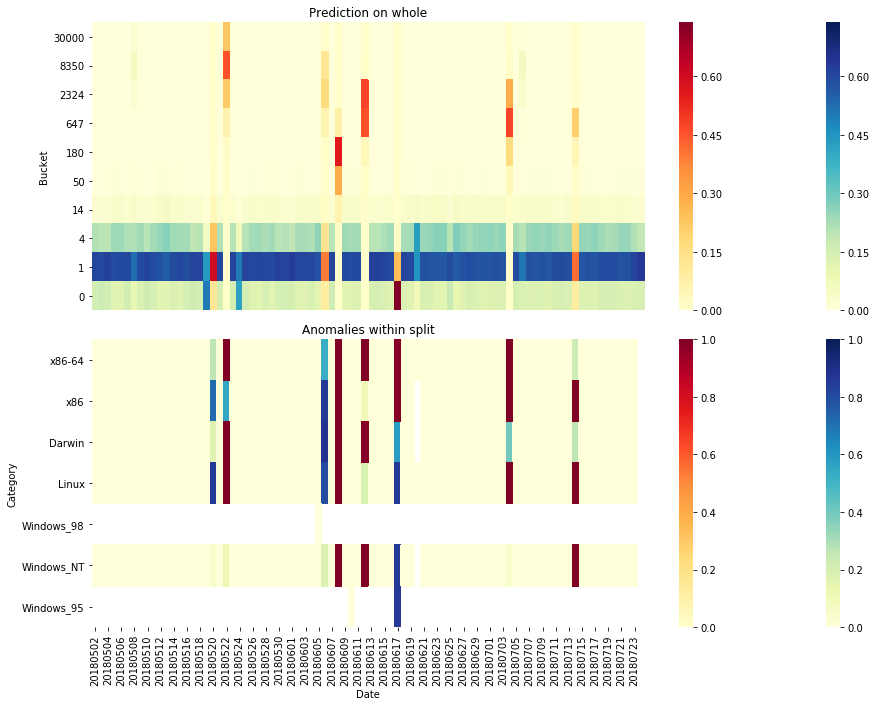

VIDEO_INFERRED_DECODE_SUSPEND_PERCENTAGE


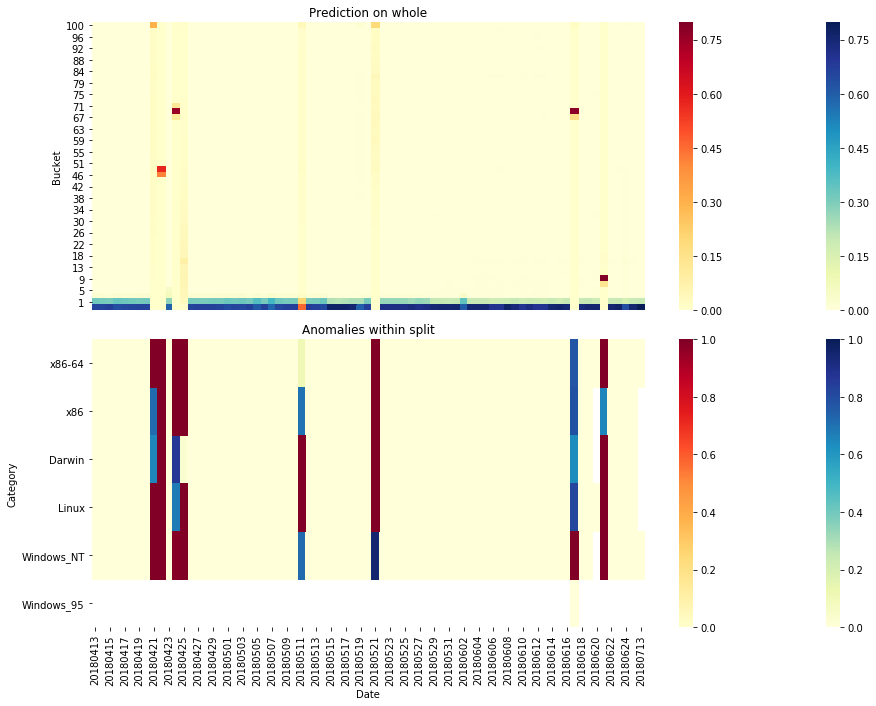

CONTENT_PAINT_TIME


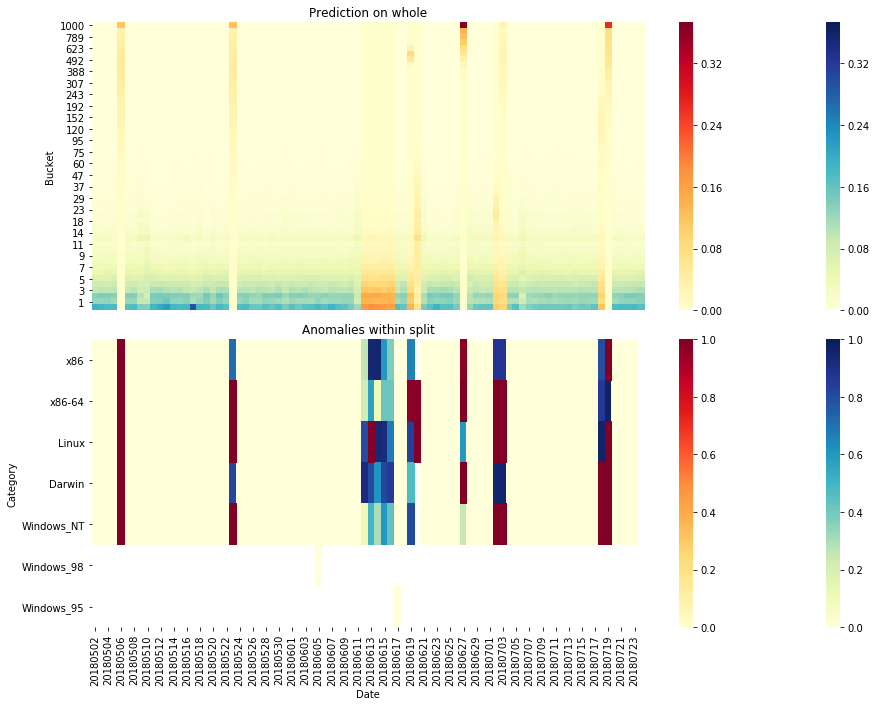

DEVTOOLS_DEBUGGER_LOAD_SOURCE_MS


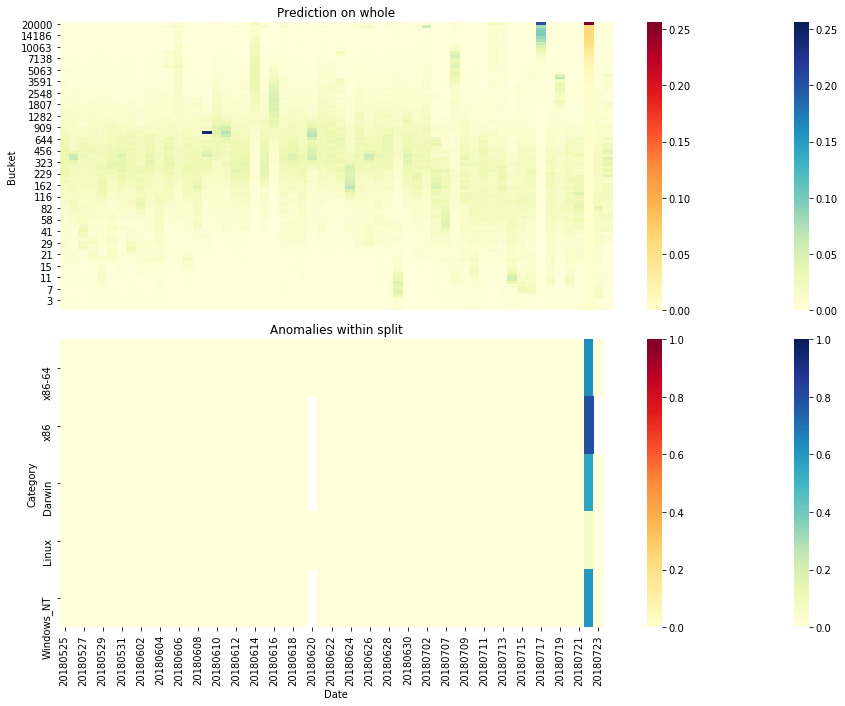

DEVTOOLS_DEVELOPERTOOLBAR_OPENED_COUNT


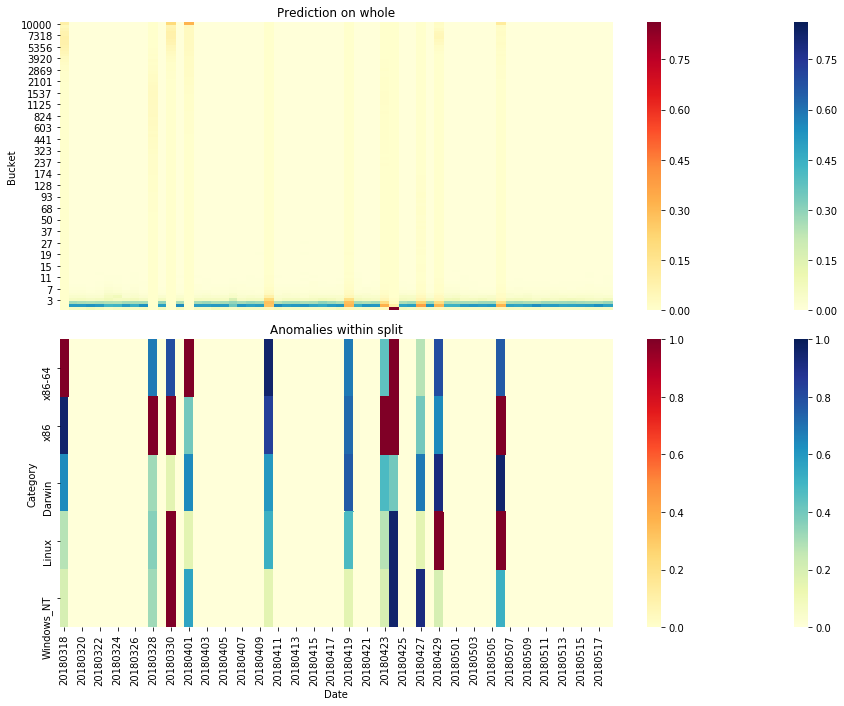

DEVTOOLS_NETMONITOR_OPENED_COUNT


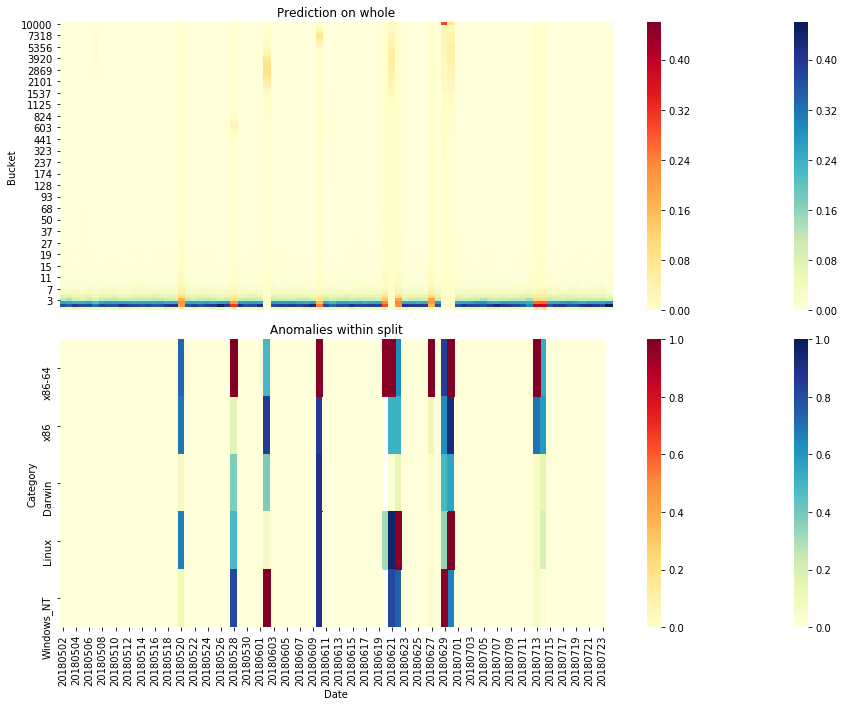

DEVTOOLS_TOOLBOX_TIME_ACTIVE_SECONDS


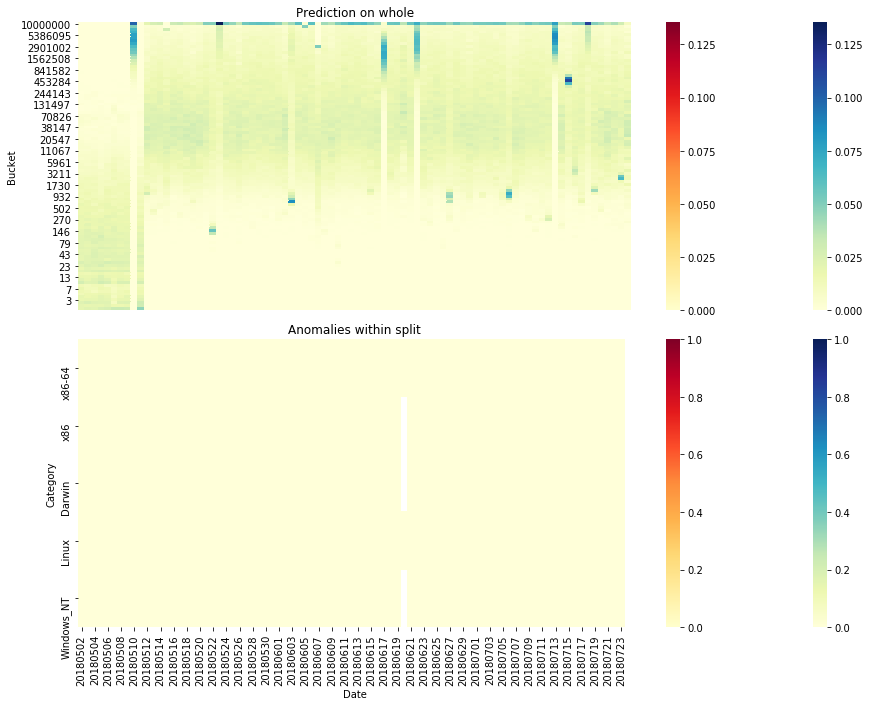

FX_SANITIZE_CACHE


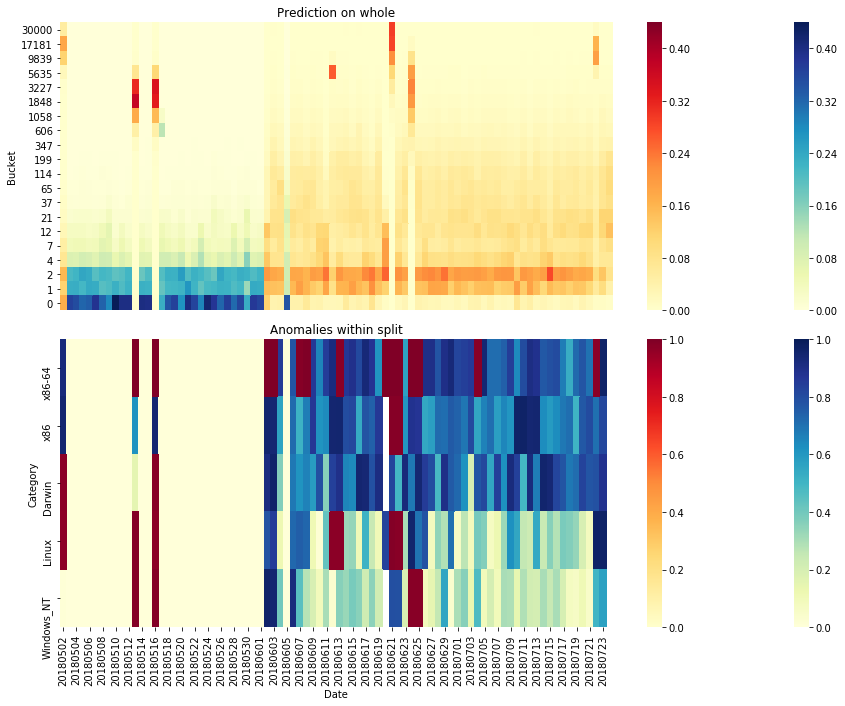

FX_TAB_CLOSE_TIME_ANIM_MS


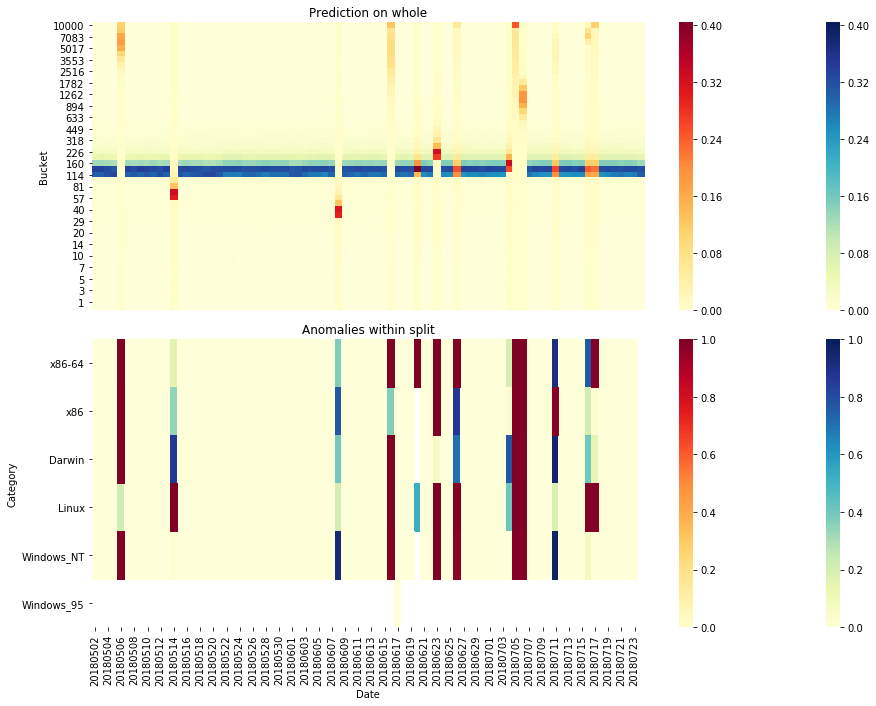

GFX_OMTP_PAINT_WAIT_TIME


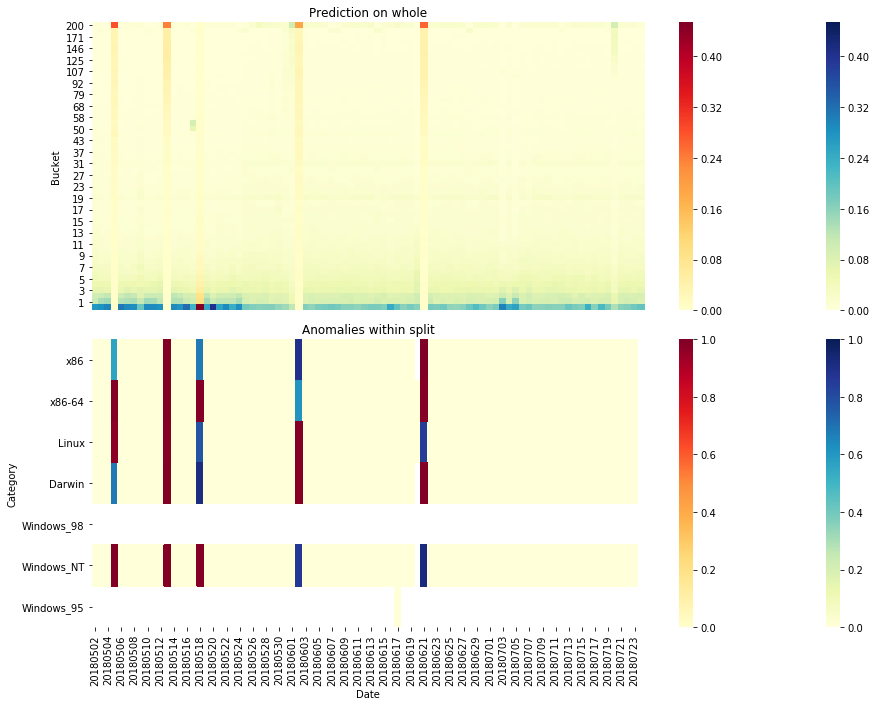

HTTP_KBREAD_PER_CONN


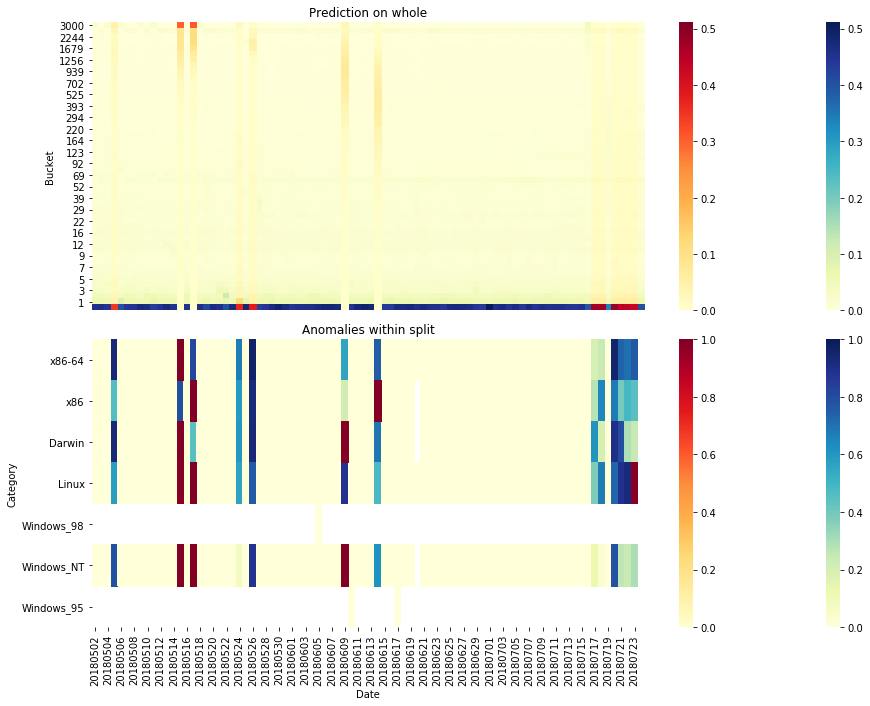

HTTP_PAGE_DNS_LOOKUP_TIME


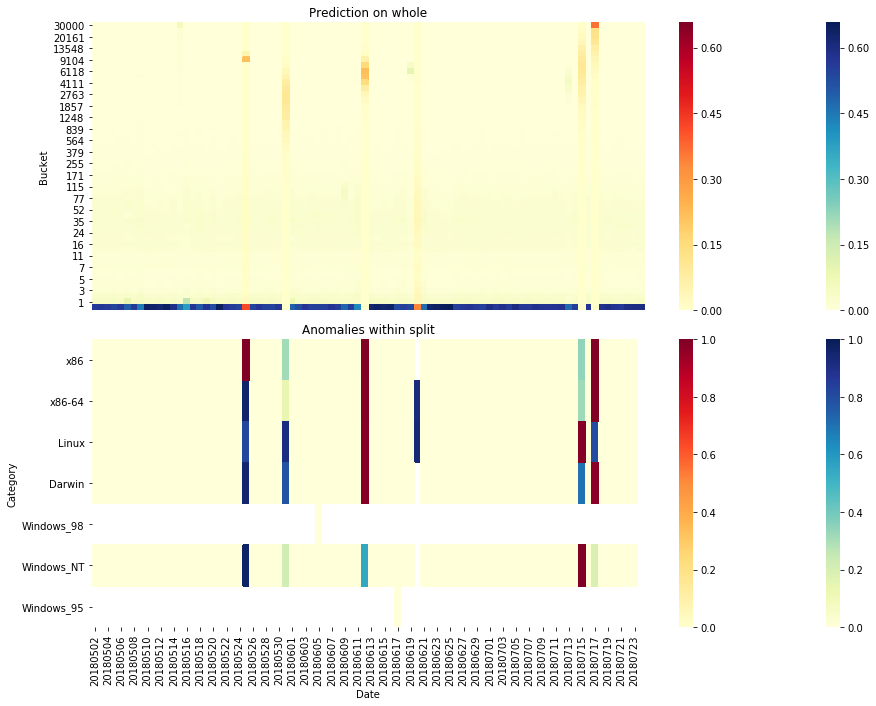

HTTP_SUB_DNS_ISSUE_TIME


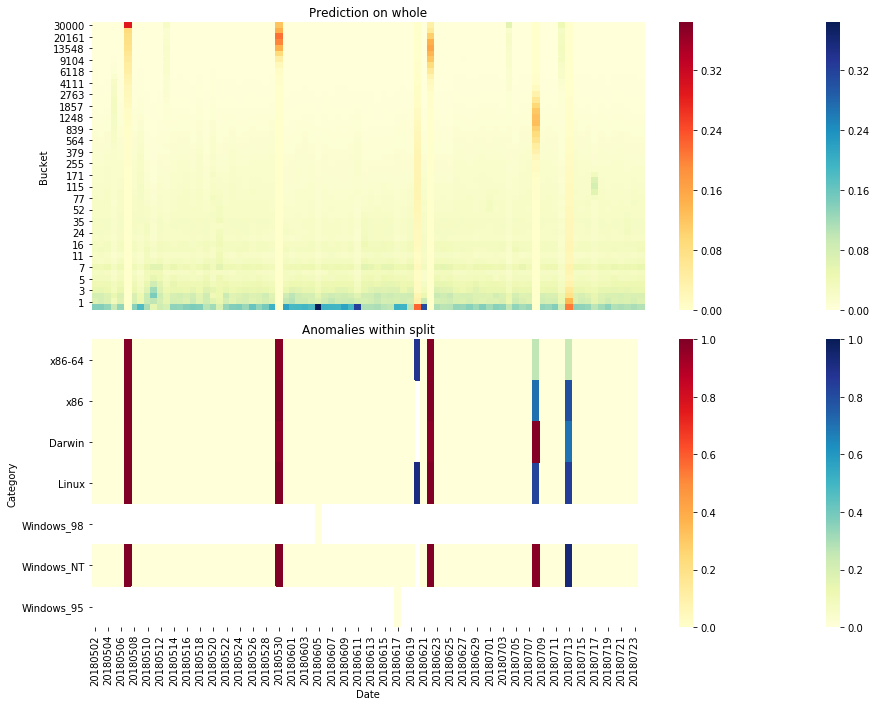

IDLE_NOTIFY_IDLE_MS


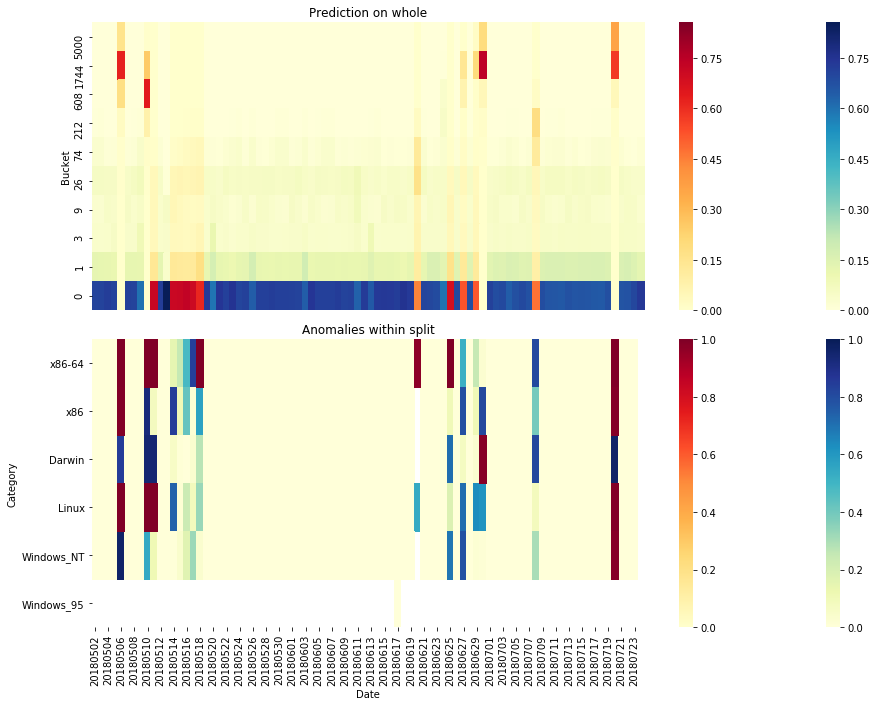

INPUT_EVENT_RESPONSE_MS


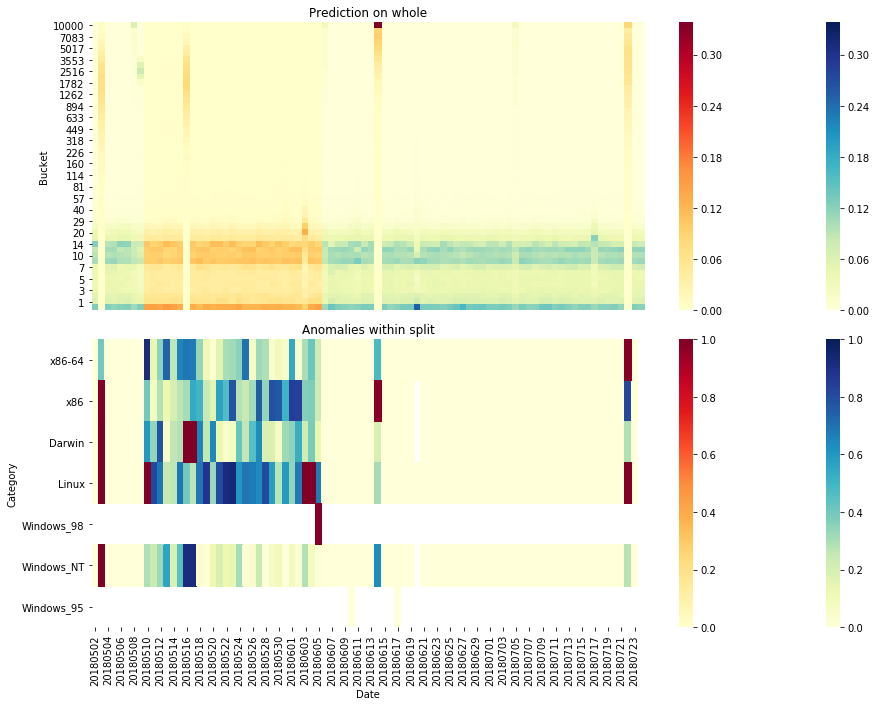

IPC_REPLY_SIZE


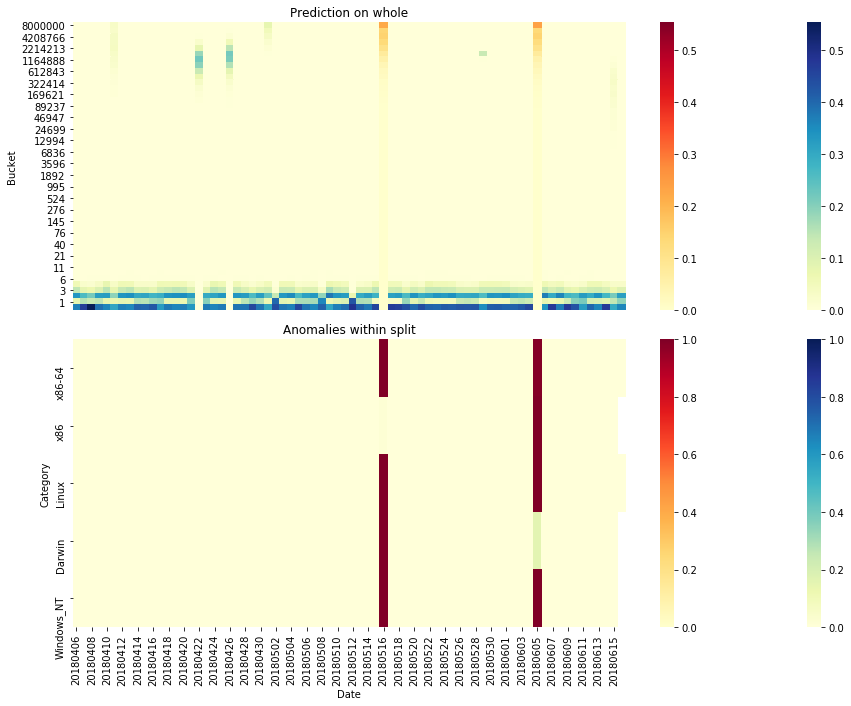

LINK_ICON_SIZES_ATTR_DIMENSION


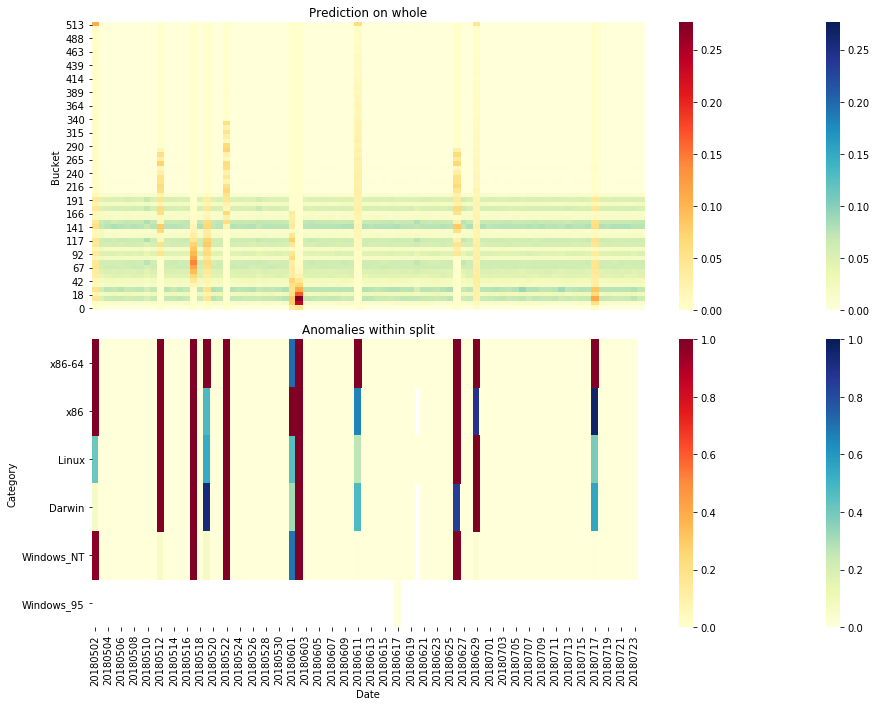

MOZ_SQLITE_COOKIES_TIME_TO_BLOCK_MAIN_THREAD_MS


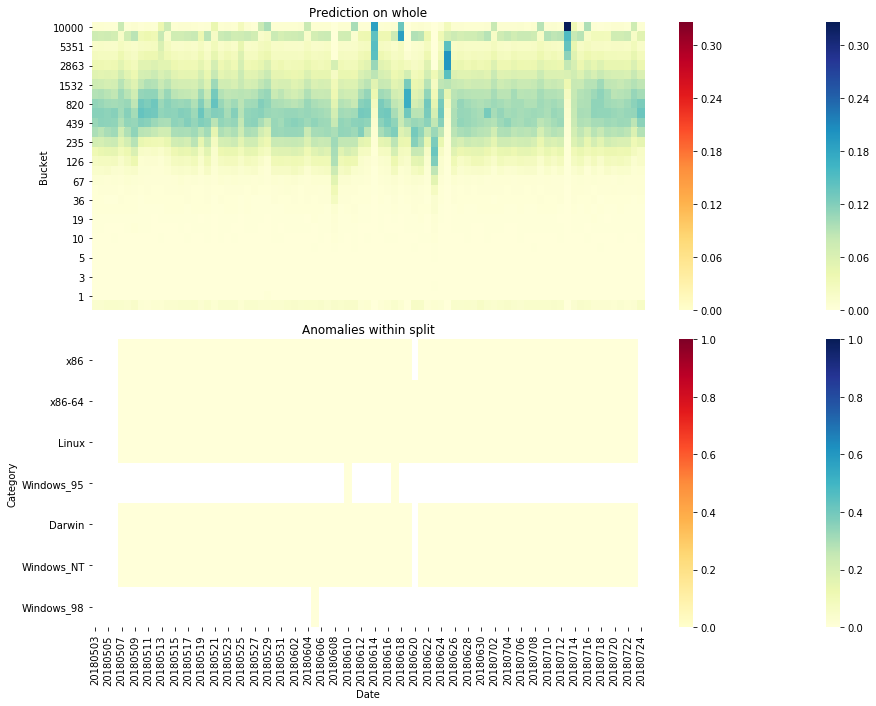

MOZ_SQLITE_OTHER_SYNC_MAIN_THREAD_MS


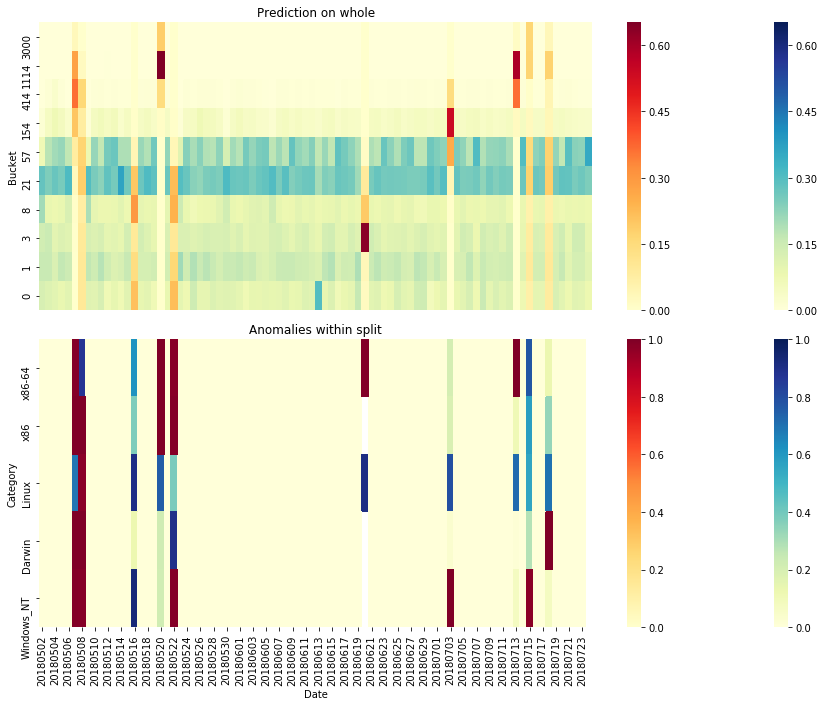

PLACES_AUTOCOMPLETE_6_FIRST_RESULTS_TIME_MS


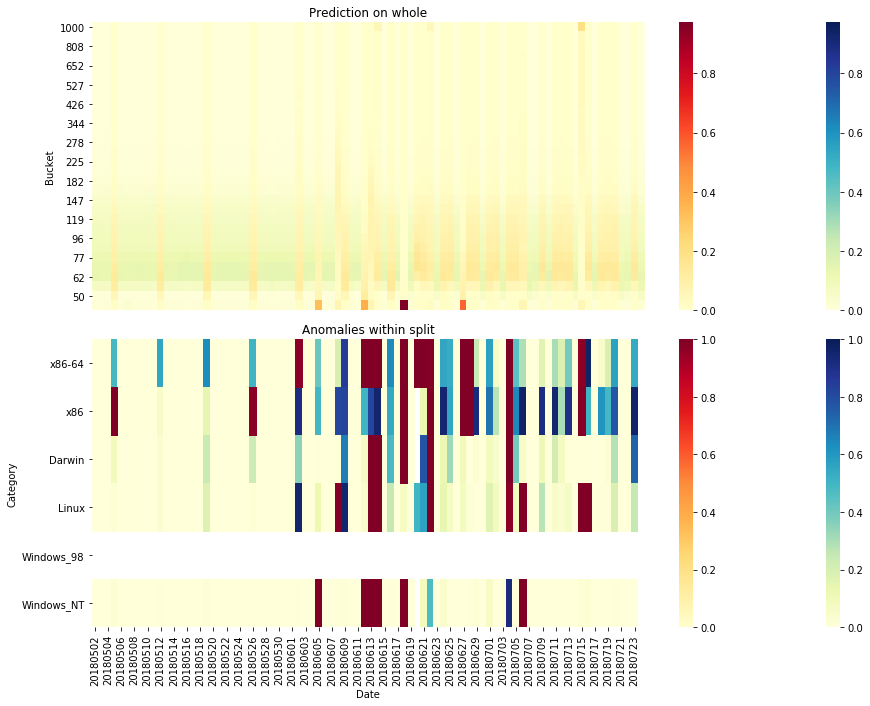

In [7]:
for m in good_metrics:
    print(m)
    y_true_df = pd.DataFrame(y_true[m], index=[0]).transpose()
    y_pred_df = y_metric_to_df(y_pred[m])
    preds_proba = pd.DataFrame(y_pred_split[m])
    preds_anom = pd.DataFrame(y_pred_split_anom[m])
    whole_df_to_join = X_metric_to_df(X_test[m]).transpose()
    
    joined_df = whole_df_to_join.join(preds_proba)
    preds_proba = joined_df[preds_proba.columns].transpose()
    whole_df = joined_df[whole_df_to_join.columns].transpose()
    
    joined_df = whole_df_to_join.join(preds_anom)
    preds_anom = joined_df[preds_anom.columns].transpose()

    plt.figure()
    ax0 = plt.axes([0, 1.1, 2, 1], label='0')
    plt.setp(ax0.get_xticklabels(), visible=False)    
    plt.setp(ax0.get_xticklines(), visible=False)    
    sns.heatmap(whole_df, cmap="YlGnBu")
    sns.heatmap(whole_df, mask=1 - y_pred_df.set_index(y_true_df.index)[0], cmap='YlOrRd')
    plt.ylabel('Bucket')
    plt.title('Prediction on whole')
    
    plt.axes([0, 0, 2, 1], label='1')
    sns.heatmap(preds_proba, cmap="YlGnBu", vmin=0, vmax=1)
    sns.heatmap(preds_proba, mask=1 - preds_anom.values, cmap='YlOrRd', vmin=0, vmax=1)
    plt.xlabel('Date')
    plt.ylabel('Category')
    plt.title('Anomalies within split')
    plt.show()